In [1]:
import pandas as pd
import numpy as np
from pvops.text.preprocess import text_remove_numbers_stopwords
from pvops.text.nlp_utils import create_stopwords
# from nltk import corpus
from nltk.tokenize import word_tokenize
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# import pickle

### Overview

This notebook walks through how to use Subject Topic Modeling (STM) methods to analyze text data. STM methods aim to cluster documents and/or terms into "topics" to gain insight into the content of a set of documents.

In particular, we will clean some data before performing Latent Dirichlet Allocation (LDA). blah blah

### Read in and clean data

Read in the asset-related inverter records. Make a combined `'FullDesc'` column that contains all the text data associated with that record.

In [ ]:
CM_df = pd.read_csv('example_data/example_ML_ticket_data.csv')
CM_df['FullDesc'] = CM_df['GeneralDesc'].astype(str) + ' ' + CM_df['CompletionDesc'].astype(str)

Drop the rows that don't have all the data we need. Then we can take a look at the dataframe.

In [3]:
CM_nonnull_df = CM_df.dropna(subset=['Date_EventStart_Consistent', 'randid', 'states', 'Commissioning_Date']).copy()
CM_nonnull_df.head(5)

,randid,Date_EventStart_Consistent,Date_EventEnd_Consistent,GeneralDesc,CompletionDesc,Asset,states,Commissioning_Date,DC_Size_kW,AC_Size_kW,PlantType,ArrayType,InverterType,InverterOEM,FullDesc
0,C2S54,2018-03-16 11:55:00,2018-03-29 13:40:00,Inverter underperforming due to unknown,Power Cycle. Hardware Replaced:,Inverter,CA,2012-07-23,181.0,250.0,Distributed Generation,NaN,central,NaN,Inverter underperforming due to unknown Power ...
1,C2S54,2017-09-22 14:40:00,2017-09-26 10:30:00,Inverter not producing due to Unknown,Field Wiring Repair. Hardware Replaced:,Inverter,CA,2012-07-23,181.0,250.0,Distributed Generation,NaN,central,NaN,Inverter not producing due to Unknown Field Wi...
2,C2S54,2017-02-01 08:00:00,2017-02-10 14:25:00,Inverter Faulted Due Hardware Malfunction,Power Cycle. Hardware Replaced:,Inverter,CA,2012-07-23,181.0,250.0,Distributed Generation,NaN,central,NaN,Inverter Faulted Due Hardware Malfunction Powe...
3,C3S300,2017-07-25 09:00:00,2017-07-25 15:01:00,All inverters not communcating but still produ...,SOLV remotely fixed comms.,Central Inverter,OR,2016-12-03,5891.0,6600.0,Utility-scale,Tracker,NaN,SMA America,All inverters not communcating but still produ...
4,C3S300,2018-06-04 09:00:00,2018-06-05 00:45:00,WO created for support on retrofit for SMA inv...,Displays replaced on all inverters on site.,Central Inverter,OR,2016-12-03,5891.0,6600.0,Utility-scale,Tracker,NaN,SMA America,WO created for support on retrofit for SMA inv...


Clean up the description by shifting to lowercase, removing stopwords, tokenizing, and transforming to a bag-of-words representation.

In [11]:
import sys
sys.path.append('../pvops/text')
from preprocess import get_bag_of_words_with_corpus_dictionary

# set to lowercase
CM_nonnull_df['FullDescCleaned'] = CM_nonnull_df['FullDesc'].str.lower()

# remove stopwords.
# note text_remove_numbers_stopwords() removes numbers and punctuation in addition to nltk stopwords,
# but doesn't include ';', so we add it below.
stopwords = create_stopwords(lst_add_words=[';'])
cleaning_func = lambda row : text_remove_numbers_stopwords(row['FullDescCleaned'], stopwords)
CM_nonnull_df['FullDescCleaned'] = CM_nonnull_df.apply(cleaning_func, axis='columns')

# tokenize and transform to bag-of-words
CM_nonnull_df['FullDescTokenized'] = [word_tokenize(desc) for desc in (CM_nonnull_df['FullDescCleaned'])]
bow_docs, dictionary = get_bag_of_words_with_corpus_dictionary(CM_nonnull_df['FullDescTokenized'])

We can take a look at an example to see how the data is transformed:

In [41]:
print('Raw:\t\t\t', CM_nonnull_df['FullDesc'][0])
print('Cleaned, tokenized:\t', CM_nonnull_df['FullDescTokenized'][0])
print('Bag-of-words:\t\t', bow_docs[0])

Raw:			 Inverter underperforming due to unknown Power Cycle. Hardware Replaced: 
Cleaned, tokenized:	 ['inverter', 'underperforming', 'due', 'unknown', 'power', 'cycle', 'hardware', 'replaced']
Bag-of-words:		 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


Now we can run Latend Dirichlet Allocation (LDA).

 and compute the coherence values.LDA is inherently random, so we run the process five times to get an idea of the spread across multiple iterations. It's also good to try several different numbers of topics to see what is most appropriate.

In [62]:
from nlp_utils import fit_lda

num_iter = 10
kvals = np.arange(5,51) # number of topics
lda_models = {}
coherence_values = {}

for num_topics in tqdm(kvals, desc='Iterating through topic counts'):
    result = fit_lda(dictionary, bow_docs, num_topics, num_iter=num_iter, random_state=num_topics*100)
    lda_models[num_topics], coherence_values[num_topics] = result

Iterating through topic counts:   0%|          | 0/46 [00:00<?, ?it/s]

Below, we summarize the results in a plot with mean and standard deviation for each topic count:

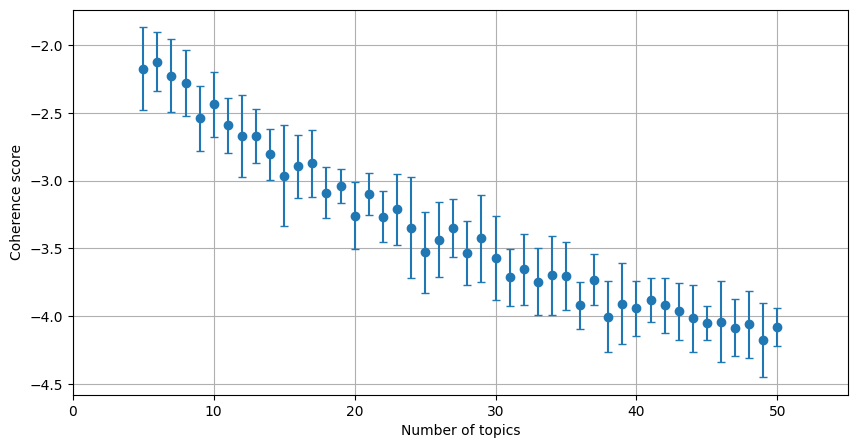

In [64]:
# Get the mean and standard deviation across multiple model runs
mean_coherence = np.array([coherence_values[kval] for kval in kvals]).mean(axis=1)
std_mean_coherence = np.array([coherence_values[kval] for kval in kvals]).std(axis=1)

# Plot coherence values
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(kvals, mean_coherence, std_mean_coherence, fmt='o', capsize=3)
ax.set_xlabel('Number of topics')
ax.set_ylabel('Coherence score')
ax.set_xlim((min(kvals)-5, max(kvals)+5))
ax.grid();

From this information, we could select a smaller set of k-values to use for further analysis. We'll just go ahead and use all the ones we tried, since there weren't that many of them to begin with.
<br><br>
Once we're happy with our selection of k-values, we can rerun the model one more time (with a new seed) for each k and write to file.

In [ ]:
for k, model, coherence in zip(kvals, models, coherences):
    print(f'{k} topics: {coherence[0] :.3f}')
    with open(f'fitted_models/stm_lda_model_k{k}.pkl', 'wb') as file:
        pickle.dump(model[0], file)

  0%|          | 0/6 [00:00<?, ?it/s]

5 topics: 0.351
10 topics: 0.415
15 topics: 0.423
20 topics: 0.423
25 topics: 0.409
30 topics: 0.385


Finally, we also write our dictionary and dataframe with embeddings to file.

In [16]:
with open('fitted_models/corpus_dictionary.pkl', 'wb') as file:
    pickle.dump(dictionary, file)

CM_nonnull_df.to_csv('example_data/example_CM_inverter_records_with_embeddings.csv', index=False)